<a href="https://colab.research.google.com/github/simon-mellergaard/GAI-with-LLMs/blob/main/Litterature/NLP_08_model_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/code/simonmellergaard/nlp-08-model-compression/edit)

In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [ ]:
# hide
# from utils import *
# setup_chapter()

In [142]:
!pip install evaluate
!pip install optuna
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.2 MB/s eta 0:00:00


# Making Transformers Efficient in Production

<img alt="Scaling BERT at Roblox" caption="How Roblox scaled BERT with knowledge distillation, dynamic padding, and weight quantization (photo courtesy of Roblox employees Quoc N. Le and Kip Kaehler)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_roblox.png?raw=1" id="roblox"/>

## Intent Detection as a Case Study

<img alt="Out of Scope Query" width="400" caption="Three exchanges between a human (right) and a text-based assistant (left) for personal finance (courtesy of Stefan Larson et al.)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_oos.png?raw=1" id="oos"/>

In [2]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

## Creating a Performance Benchmark

In [4]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # We'll define this later
        pass

    def compute_size(self):
        # We'll define this later
        pass

    def time_pipeline(self):
        # We'll define this later
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [5]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

README.md: 0.00B [00:00, ?B/s]

plus/train-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

plus/validation-00000-of-00001.parquet:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

plus/test-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [6]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [7]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [8]:
import evaluate

accuracy_score = evaluate.load('accuracy')

In [9]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [10]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [11]:
import torch
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [12]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 103.984
Latency (ms) - 102.745
Latency (ms) - 88.298


In [13]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

<>:18: SyntaxWarning: invalid escape sequence '\-'
<>:18: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipython-input-720322860.py:18: SyntaxWarning: invalid escape sequence '\-'
  print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")


In [14]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Average latency (ms) - 27.60 +\- 14.07
Accuracy on test set - 0.867


## Making Models Smaller via Knowledge Distillation

### Knowledge Distillation for Fine-Tuning

<img alt="Soft Probabilities" caption="Comparison of a hard label that is one-hot encoded (left), softmax probabilities (middle), and softened class probabilities (right)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_soft-probs.png?raw=1" id="soft-probs"/>

<img alt="Knowledge distillation" caption="The knowledge distillation process" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_kd.png?raw=1" id="kd"/>

### Knowledge Distillation for Pretraining

### Creating a Knowledge Distillation Trainer

In [15]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### Choosing a Good Student Initialization

In [17]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [18]:
# Logging in to Huggingface and wandb
import os
from google.colab import userdata
from huggingface_hub import login as login_hf
from wandb import login as login_wandb
os.environ['HF_TOKEN'] = userdata.get('HF')
os.environ['WANDB_TOKEN'] = userdata.get('wandb')
login_hf(os.environ['HF_TOKEN'])
login_wandb(key = os.environ['WANDB_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: simonmellergaard (simonmellergaard-aarhus-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [19]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [20]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, eval_strategy = "epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
    push_to_hub=True)

In [ ]:
# Simon: This should probably not be run.
# student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
# student_training_args.disable_tqdm = False
# student_training_args.save_steps = 1e9
# student_training_args.log_level = 40

In [21]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [22]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [23]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

In [24]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [25]:
#https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-emotion
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [ ]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

/tmp/ipython-input-1291996959.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.339083,0.730968
2,3.833100,1.929619,0.844839
3,3.833100,1.202655,0.896452
4,1.751700,0.895604,0.911935
5,0.943900,0.806354,0.916452


TrainOutput(global_step=1590, training_loss=2.0980418607123994, metrics={'train_runtime': 318.3834, 'train_samples_per_second': 239.491, 'train_steps_per_second': 4.994, 'total_flos': 414689637990180.0, 'train_loss': 2.0980418607123994, 'epoch': 5.0})

In [ ]:
distilbert_trainer.push_to_hub("Training completed!")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...d-finetuned-clinc/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...d-finetuned-clinc/model.safetensors:   9%|9         | 25.2MB /  268MB            

  ...ents.1758542064.6a1c91e9d45a.1271.0: 100%|##########| 15.1kB / 15.1kB            

CommitInfo(commit_url='https://huggingface.co/simon-mellergaard/distilbert-base-uncased-finetuned-clinc/commit/315a0baf53820c9fcf01dd5426428f72ac158ddd', commit_message='Training completed!', commit_description='', oid='315a0baf53820c9fcf01dd5426428f72ac158ddd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/simon-mellergaard/distilbert-base-uncased-finetuned-clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='simon-mellergaard/distilbert-base-uncased-finetuned-clinc'), pr_revision=None, pr_num=None)

In [26]:
finetuned_ckpt = "simon-mellergaard/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [27]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 7.69 +\- 3.28
Accuracy on test set - 0.853


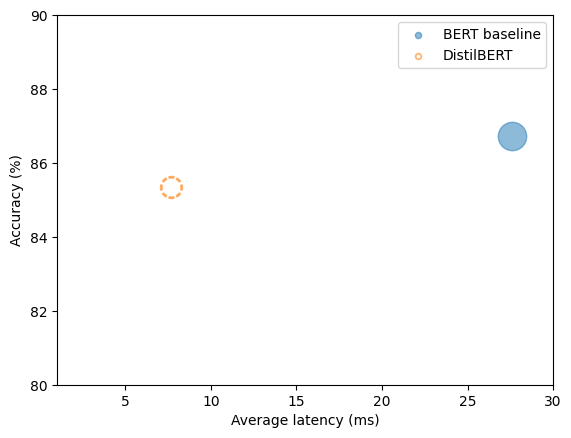

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legend_handles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

### Finding Good Hyperparameters with Optuna

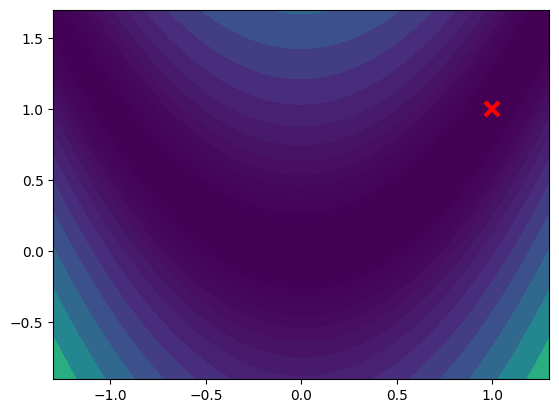

In [30]:
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2

X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [31]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [34]:
import optuna

study = optuna.create_study()
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=1000)

In [ ]:
study.best_params

{'x': 0.978744849116018, 'y': 0.9597909344570623}

In [32]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [ ]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇██
eval/loss,█▄▂▁▁
eval/runtime,█▇▁▄▇
eval/samples_per_second,▁▂█▅▂
eval/steps_per_second,▁▂█▅▂
train/epoch,▁▂▃▅▅▆███
train/global_step,▁▂▃▄▅▆███
train/grad_norm,▇█▁
train/learning_rate,█▅▁
train/loss,█▃▁
eval/accuracy,0.91645


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.193593,0.580645
2,0.310500,0.095190,0.819032
3,0.310500,0.064745,0.880645
4,0.110500,0.050572,0.893871
5,0.072000,0.042386,0.905484
6,0.072000,0.037700,0.910645
7,0.058000,0.035510,0.912581
8,0.052200,0.034572,0.915484


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇█████
eval/loss,█▄▂▂▁▁▁▁
eval/runtime,▂▁▁▁▇▁▁█
eval/samples_per_second,▆▇▇█▂██▁
eval/steps_per_second,▆▇▇█▂██▁
train/epoch,▁▂▂▃▃▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▄▅▅▆▆▇███
train/grad_norm,▇█▃▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.91548


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.192206,0.588387
2,0.310300,0.092624,0.827419
3,0.310300,0.061736,0.885484
4,0.107800,0.047319,0.896129
5,0.068300,0.038819,0.910323
6,0.068300,0.033778,0.917419
7,0.053300,0.031004,0.920645
8,0.046200,0.028755,0.922903
9,0.046200,0.027844,0.925806
10,0.042800,0.027435,0.926452


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇██████
eval/loss,█▄▂▂▁▁▁▁▁▁
eval/runtime,▁▁▁▆▁▅▁▁█▁
eval/samples_per_second,█▇▇▂▇▃█▇▁█
eval/steps_per_second,█▇▇▂▇▃█▇▁█
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,▇█▃▂▁▁
train/learning_rate,█▇▅▄▂▁
train/loss,█▃▂▁▁▁
eval/accuracy,0.92645


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.199752,0.558710
2,0.314300,0.104497,0.798065
3,0.314300,0.075821,0.862581
4,0.120800,0.063935,0.876774
5,0.087300,0.060211,0.878065


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆███
eval/loss,█▃▂▁▁
eval/runtime,▁▃█▁▁
eval/samples_per_second,█▆▁██
eval/steps_per_second,█▆▁██
train/epoch,▁▂▃▅▅▆███
train/global_step,▁▂▃▄▅▆███
train/grad_norm,▆█▁
train/learning_rate,█▅▁
train/loss,█▂▁
eval/accuracy,0.87806


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.196224,0.574516
2,0.313100,0.097648,0.818387
3,0.313100,0.067278,0.876129
4,0.113200,0.053379,0.892258
5,0.075200,0.045501,0.900968
6,0.075200,0.041436,0.905484
7,0.062200,0.040160,0.907742


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifi

eval/accuracy,▁▆▇████
eval/loss,█▄▂▂▁▁▁
eval/runtime,▁▁▁█▁▁█
eval/samples_per_second,███▁██▁
eval/steps_per_second,███▁██▁
train/epoch,▁▂▂▃▄▅▅▆▇▇██
train/global_step,▁▂▂▃▄▅▅▆▇▇██
train/grad_norm,▆█▂▁
train/learning_rate,█▆▃▁
train/loss,█▂▁▁
eval/accuracy,0.90774


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.291256,0.640645
2,0.461000,0.119186,0.840645
3,0.461000,0.070149,0.891290
4,0.139900,0.051237,0.903548
5,0.079900,0.041529,0.920000
6,0.079900,0.036895,0.921290
7,0.061900,0.034703,0.925484
8,0.055200,0.033727,0.924839


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifi

eval/accuracy,▁▆▇▇████
eval/loss,█▃▂▁▁▁▁▁
eval/runtime,▁▁▁▁█▁▁▁
eval/samples_per_second,█▇██▁█▇▇
eval/steps_per_second,█▇██▁█▇▇
train/epoch,▁▂▂▃▃▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▄▅▅▆▆▇███
train/grad_norm,▇█▃▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▂▁▁▁
eval/accuracy,0.92484


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.198613,0.580323


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.58032
eval/loss,0.19861
eval/runtime,5.3108
eval/samples_per_second,583.714


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.198445,0.586129
2,0.317900,0.096745,0.823548
3,0.317900,0.065316,0.881613
4,0.112400,0.050777,0.894516
5,0.072700,0.042416,0.905484
6,0.072700,0.037672,0.911613


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇███
eval/loss,█▄▂▂▁▁
eval/runtime,▁▁▁▁█▂
eval/samples_per_second,████▁▆
eval/steps_per_second,████▁▆
train/epoch,▁▂▂▄▄▅▆▇█
train/global_step,▁▂▂▄▄▅▆▇█
train/grad_norm,▆█▁
train/learning_rate,█▅▁
train/loss,█▂▁
eval/accuracy,0.91161


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.192098,0.577097


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.5771
eval/loss,0.1921
eval/runtime,5.3761
eval/samples_per_second,576.625


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.199476,0.573226


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.57323
eval/loss,0.19948
eval/runtime,5.3807
eval/samples_per_second,576.137


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.213039,0.590645
2,0.337000,0.105659,0.818387


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▅█
train/global_step,▁▅█
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.81839


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.188642,0.581290
2,0.304700,0.091501,0.825161
3,0.304700,0.061288,0.885161
4,0.106300,0.047167,0.895161
5,0.067700,0.038790,0.909032
6,0.067700,0.033808,0.917097
7,0.053000,0.031054,0.920968
8,0.045900,0.028802,0.922581


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇████
eval/loss,█▄▂▂▁▁▁▁
eval/runtime,▁▁▂█▁▁▁▁
eval/samples_per_second,█▇▅▁▇███
eval/steps_per_second,█▇▅▁▇███
train/epoch,▁▂▂▃▃▄▅▅▆▆▇██
train/global_step,▁▂▂▃▃▄▅▅▆▆▇██
train/grad_norm,▇█▃▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.92258


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.406141,0.669032
2,0.641200,0.136193,0.842903
3,0.641200,0.070546,0.902258
4,0.160100,0.050595,0.916774
5,0.079200,0.041633,0.927097
6,0.079200,0.036909,0.929032
7,0.059500,0.034651,0.931935
8,0.051500,0.032440,0.932258
9,0.051500,0.031666,0.933871
10,0.047800,0.031159,0.935806


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifi

eval/accuracy,▁▆▇███████
eval/loss,█▃▂▁▁▁▁▁▁▁
eval/runtime,█▃▁▁▂▁▁██▁
eval/samples_per_second,▁▄██▅██▁▁█
eval/steps_per_second,▁▄██▅██▁▁█
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,█▆▃▁▁▁
train/learning_rate,█▇▅▄▂▁
train/loss,█▂▁▁▁▁
eval/accuracy,0.93581


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.206136,0.604194
2,0.332200,0.096861,0.833226
3,0.332200,0.063082,0.886129
4,0.113000,0.047685,0.898387
5,0.070100,0.038716,0.914516
6,0.070100,0.033571,0.918387
7,0.054400,0.030794,0.920968
8,0.046900,0.028511,0.923871
9,0.046900,0.027615,0.927419


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇█████
eval/loss,█▄▂▂▁▁▁▁▁
eval/runtime,▁▁▁▁▁▁██▁
eval/samples_per_second,█▇██▇█▁▁█
eval/steps_per_second,█▇██▇█▁▁█
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train/global_step,▁▂▂▃▃▄▄▄▅▆▆▇▇█
train/grad_norm,▇█▃▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.92742


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.406141,0.669032
2,0.641200,0.136193,0.842903
3,0.641200,0.070546,0.902258
4,0.160100,0.050595,0.916774
5,0.079200,0.041633,0.927097
6,0.079200,0.036909,0.929032
7,0.059500,0.034651,0.931935
8,0.051500,0.032440,0.932258
9,0.051500,0.031666,0.933871
10,0.047800,0.031159,0.935806


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifi

eval/accuracy,▁▆▇███████
eval/loss,█▃▂▁▁▁▁▁▁▁
eval/runtime,▁▁▁▁▁▁▁█▆▁
eval/samples_per_second,█▇█████▁▂█
eval/steps_per_second,█▇█████▁▂█
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,█▆▃▁▁▁
train/learning_rate,█▇▅▄▂▁
train/loss,█▂▁▁▁▁
eval/accuracy,0.93581


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.409055,0.668387
2,0.643200,0.139481,0.842581
3,0.643200,0.072779,0.899032
4,0.163500,0.052250,0.914194
5,0.081700,0.042972,0.926774
6,0.081700,0.038291,0.929677
7,0.061700,0.036021,0.930645
8,0.054000,0.034181,0.931613
9,0.054000,0.033687,0.933871


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇█████
eval/loss,█▃▂▁▁▁▁▁▁
eval/runtime,▁▁▁▁▁▁▁█▇
eval/samples_per_second,█▇█▇███▁▁
eval/steps_per_second,█▇█▇███▁▁
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▄▄▄▅▆▆▇▇██
train/grad_norm,█▆▃▁▁
train/learning_rate,█▆▅▃▁
train/loss,█▂▁▁▁
eval/accuracy,0.93387


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.230157,0.614194


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.61419
eval/loss,0.23016
eval/runtime,5.3534
eval/samples_per_second,579.068


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.230157,0.614194


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.61419
eval/loss,0.23016
eval/runtime,5.4176
eval/samples_per_second,572.207


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.202645,0.600000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.6
eval/loss,0.20264
eval/runtime,5.4056
eval/samples_per_second,573.485


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.230157,0.614194


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.61419
eval/loss,0.23016
eval/runtime,5.3826
eval/samples_per_second,575.934


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.287032,0.643226
2,0.458200,0.114328,0.845484
3,0.458200,0.065812,0.895806
4,0.134700,0.047340,0.907419
5,0.074800,0.038024,0.922903
6,0.074800,0.033301,0.925484
7,0.056500,0.030890,0.930645
8,0.048800,0.028707,0.929032
9,0.048800,0.027984,0.932258


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.


In [ ]:
print(best_run)

BestRun(run_id='11', objective=0.9358064516129032, hyperparameters={'num_train_epochs': 10, 'alpha': 0.28379082112894494, 'temperature': 2}, run_summary=None)


In [43]:
from transformers.trainer_utils import BestRun
best_run = BestRun(run_id='11', objective=0.9358064516129032, hyperparameters={'num_train_epochs': 10, 'alpha': 0.28379082112894494, 'temperature': 2}, run_summary=None)

In [44]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

/tmp/ipython-input-1291996959.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.230163,0.713226
2,1.539000,0.605856,0.870968
3,1.539000,0.355481,0.919032
4,0.562500,0.269605,0.932903
5,0.276900,0.239537,0.937097
6,0.276900,0.228037,0.940645
7,0.211700,0.221750,0.942581
8,0.191000,0.216874,0.941290
9,0.191000,0.214791,0.944194
10,0.183100,0.213550,0.943871


In [45]:
distil_trainer.push_to_hub("Training complete")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...d-clinc/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...d-clinc/model.safetensors:  12%|#2        | 33.4MB /  268MB            

CommitInfo(commit_url='https://huggingface.co/simon-mellergaard/distilbert-base-uncased-distilled-clinc/commit/b87f803b6790f022fb74ee8f69fdaec34e88728c', commit_message='Training complete', commit_description='', oid='b87f803b6790f022fb74ee8f69fdaec34e88728c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/simon-mellergaard/distilbert-base-uncased-distilled-clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='simon-mellergaard/distilbert-base-uncased-distilled-clinc'), pr_revision=None, pr_num=None)

### Benchmarking Our Distilled Model

In [46]:
distilled_ckpt = "simon-mellergaard/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


Model size (MB) - 255.88
Average latency (ms) - 4.29 +\- 0.68
Accuracy on test set - 0.877


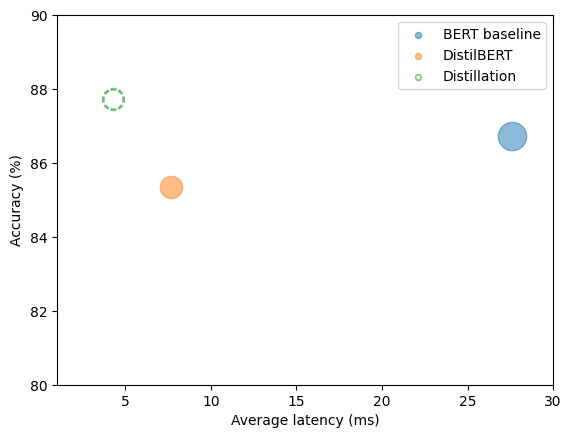

In [47]:
plot_metrics(perf_metrics, optim_type)

## Making Models Faster with Quantization

### Sidebar: A Primer on Floating-Point and Fixed-Point Numbers

### End sidebar

<img alt="Mapping floating-point numbers to 8-bit integers" width="800" caption="Quantizing floating-point numbers as unsigned 8-bit integers (courtesy of Manas Sahni)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_fp32-to-int8.png?raw=1" id="fp32toint8"/>

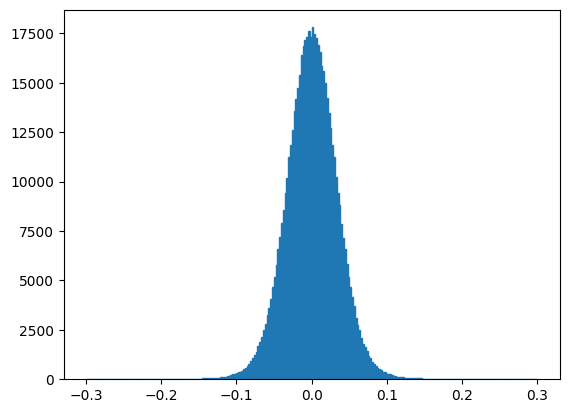

In [52]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().cpu().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [53]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [54]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -8,  -5,   5,  ...,   0,   6,  -4],
        ...,
        [  6,   0,  13,  ...,   0,   6,  -1],
        [  0,  -3, -12,  ...,  12,  -7, -13],
        [-12,  -1,  -9,  ...,   8,   2,  -1]], device='cuda:0',
       dtype=torch.int8)

In [84]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -8,  -5,   5,  ...,   0,   6,  -4],
        ...,
        [  6,   0,  13,  ...,   0,   6,  -1],
        [  0,  -3, -12,  ...,  12,  -7, -13],
        [-12,  -1,  -9,  ...,   8,   2,  -1]], device='cuda:0',
       dtype=torch.int8)

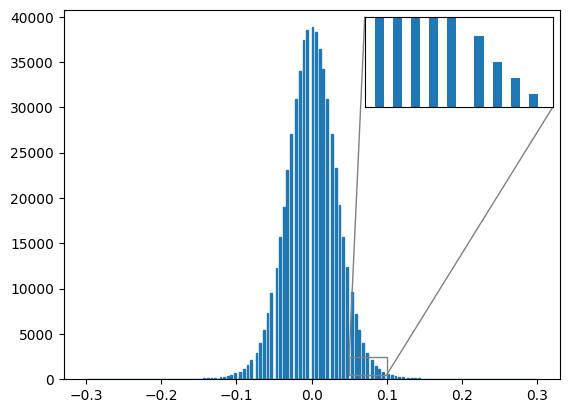

In [74]:
#id weight-quantization
#alt Effect of quantization on a transformer's weights
#caption Effect of quantization on a transformer's weights
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# Create histogram
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().cpu().numpy(),
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# Create zoom inset
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().cpu().numpy(),
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [75]:
%%timeit
weights @ weights

208 µs ± 1.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [76]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [105]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

NotImplementedError: Could not run 'quantized::mul' with arguments from the 'QuantizedCUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::mul' is only available for these backends: [Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMTIA, AutogradMAIA, AutogradMeta, Tracer, AutocastCPU, AutocastMTIA, AutocastMAIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at /pytorch/aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
QuantizedCPU: registered at /pytorch/aten/src/ATen/native/quantized/cpu/qmul.cpp:425 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at /pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:375 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:104 [backend fallback]
AutogradOther: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:87 [backend fallback]
AutogradMPS: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:95 [backend fallback]
AutogradXPU: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:108 [backend fallback]
AutogradLazy: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:91 [backend fallback]
AutogradMTIA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMAIA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMeta: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:99 [backend fallback]
Tracer: registered at /pytorch/torch/csrc/autograd/TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:322 [backend fallback]
AutocastMTIA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:466 [backend fallback]
AutocastMAIA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:504 [backend fallback]
AutocastXPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:542 [backend fallback]
AutocastMPS: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:475 [backend fallback]
PreDispatch: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:198 [backend fallback]


In [63]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

/tmp/ipython-input-2099325647.py:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

In [149]:
from torch.quantization import quantize_dynamic

model_ckpt = "simon-mellergaard/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

/tmp/ipython-input-1552078689.py:8: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)


### Benchmarking Our Quantized Model

In [130]:
pipe = pipeline("text-classification", model=model_quantized.to("cpu"),
                tokenizer=tokenizer, device="cpu")
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Device set to use cpu


Model size (MB) - 132.39
Average latency (ms) - 46.63 +\- 30.26
Accuracy on test set - 0.891


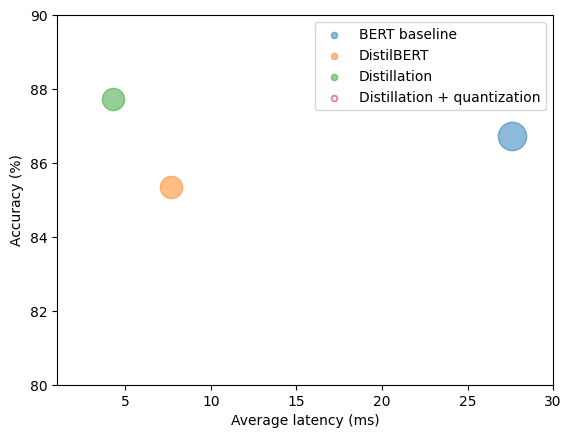

In [132]:
plot_metrics(perf_metrics, optim_type)

## Optimizing Inference with ONNX and the ONNX Runtime

<img alt="Example ONNX graph" width="500" caption="A section of the ONNX graph for BERT-base, visualized in Netron" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_bert-onnx.png?raw=1" id="bert-onnx"/>

<img alt="Architecture of the ONNX and ONNX Runtime ecosystem" width="500" caption="Architecture of the ONNX and ONNX Runtime ecosystem (courtesy of the ONNX Runtime team)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_onnx-ort.png?raw=1" id="onnx-ort"/>

In [135]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [148]:
help(convert)

Help on function convert in module transformers.convert_graph_to_onnx:

convert(framework: str, model: str, output: pathlib.Path, opset: int, tokenizer: Optional[str] = None, use_external_format: bool = False, pipeline_name: str = 'feature-extraction', **model_kwargs)
    Convert the pipeline object to the ONNX Intermediate Representation (IR) format

    Args:
        framework: The framework the pipeline is backed by ("pt" or "tf")
        model: The name of the model to load for the pipeline
        output: The path where the ONNX graph will be stored
        opset: The actual version of the ONNX operator set to use
        tokenizer: The name of the model to load for the pipeline, default to the model's name if not provided
        use_external_format:
            Split the model definition from its parameters to allow model bigger than 2GB (PyTorch only)
        pipeline_name: The kind of pipeline to instantiate (ner, question-answering, etc.)
        model_kwargs: Keyword argumen

In [154]:
model_ckpt = "simon-mellergaard/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [162]:
from transformers.convert_graph_to_onnx import convert

model_ckpt = "simon-mellergaard/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

/usr/local/lib/python3.12/dist-packages/transformers/convert_graph_to_onnx.py:361: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: simon-mellergaard/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='simon-mellergaard/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word

Device set to use cuda:0


Using framework PyTorch: 2.8.0+cu126


RuntimeError: Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)

In [143]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [151]:
onnx_model = create_model_for_provider(onnx_model_path)

NoSuchFile: [ONNXRuntimeError] : 3 : NO_SUCHFILE : Load model from onnx/model.onnx failed:Load model onnx/model.onnx failed. File doesn't exist

In [163]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

NameError: name 'onnx_model' is not defined

In [164]:
np.argmax(logits_onnx)

NameError: name 'logits_onnx' is not defined

In [ ]:
clinc_enc["test"][0]["labels"]

In [ ]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [ ]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

In [ ]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [ ]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [ ]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

## Making Models Sparser with Weight Pruning

### Sparsity in Deep Neural Networks

<img alt="Network Pruning" width="500" caption="Weights and neurons before and after pruning (courtesy of Song Han)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_network-pruning.png?raw=1" id="network-pruning"/>

### Weight Pruning Methods

#### Magnitude pruning

In [ ]:
#id sparsity-scheduler
#alt Sparsity scheduler
#caption The cubic sparsity scheduler used for pruning
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()

#### Movement pruning

<img alt="Magnitude vs Movement Pruning" width="700" caption="Comparison of weights removed (in gray) during magnitude pruning (left) and movement pruning (right)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_magnitude-vs-movement.png?raw=1" id="magnitude-vs-movement"/>

<img alt="Pruning Distributions" width="500" caption="Distribution of remaining weights for magnitude pruning (MaP) and movement pruning (MvP)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_pruning-dists.png?raw=1" id="pruning-dists"/>

## Conclusion